In [1]:
beta = 0.2857
gamma = 0.1428
path = 'out.moreno_health'

## NDlib com o igraph

In [2]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as sir
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from igraph import *
import graph_tool as gt
import graph_tool.spectral as gtsp
import graph_tool.stats as gts
import graph_tool.centrality as gtc
import graph_tool.draw as gtd
import graph_tool.dynamics as gtds
import graph_tool.topology as gtt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
%matplotlib inline

import tqdm

def nop(it, *a, **k):
    return it

tqdm.tqdm = nop

np.set_printoptions(suppress=True)

no display found. Using non-interactive Agg backend


/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1501: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


Visualização do modelo utilizando o NDLIB para execução do SIR

In [3]:
graph = Graph.Read_Ncol(path)
graph.to_undirected(mode="collapse", combine_edges=None)

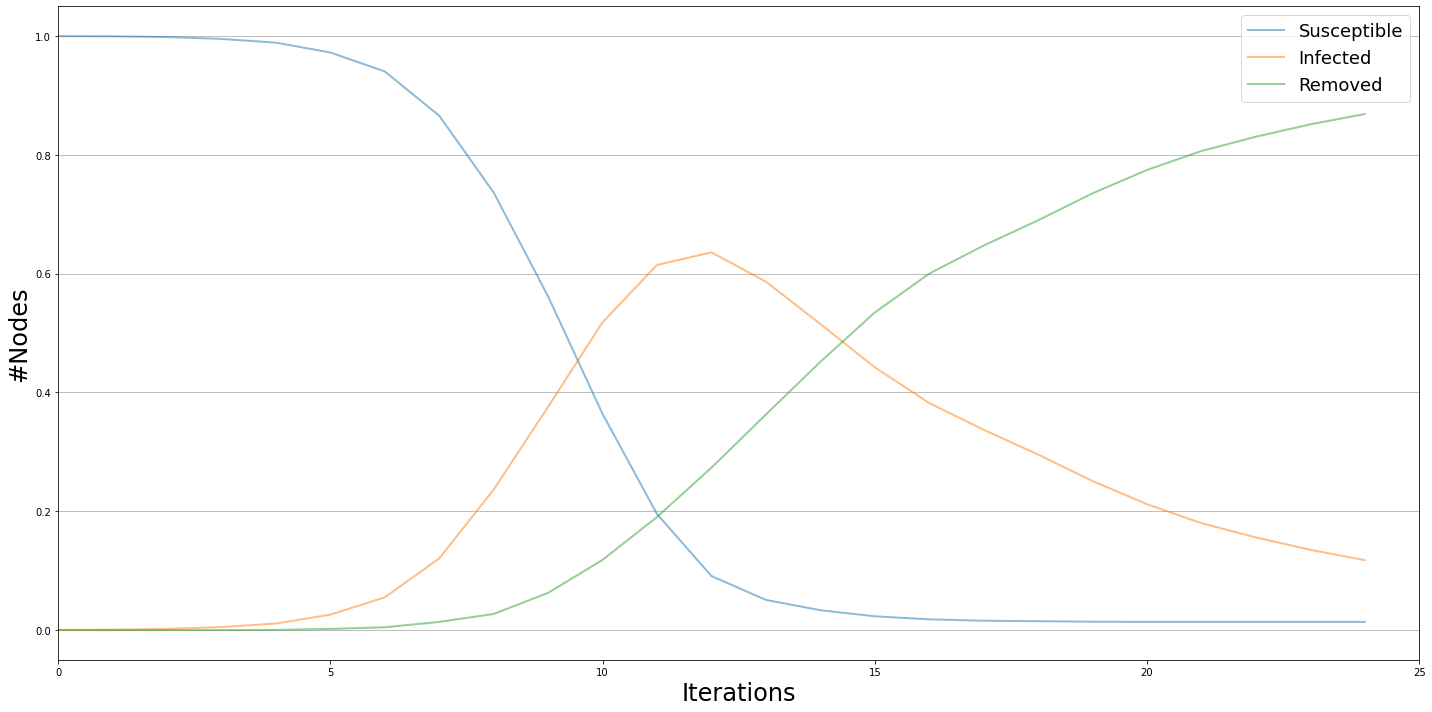

In [4]:
model = sir.SIRModel(graph)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
cfg.add_model_parameter('alpha', None)
#cfg.add_model_initial_configuration("Infected", [21,20,1,25])
infected_nodes = ['0']
cfg.add_model_initial_configuration("Infected", infected_nodes)
#cfg.add_model_initial_configuration("Removed", [])

model.set_initial_status(cfg)
iterations = model.iteration_bunch(25, node_status=True)
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

## Usando o graph-tool

In [5]:
graph = gt.load_graph_from_csv(path, csv_options={"delimiter": " "},directed=False)
gts.remove_parallel_edges(graph)
grau = graph.get_out_degrees(graph.get_vertices())
#pos = gtd.arf_layout(graph, max_iter=import networkx as nx0)

In [6]:
# Sobre a matriz de adjacências e um possível limiar epidêmico
adj = gtsp.adjacency(graph)
autovalor = gtc.eigenvector(graph)[0]
# beta*autovalor/gamma

* Gerou-se a infecção a partir de um nó de menor grau e a partir do nó de maior grau.
* A variação do número de infectados a partir do nó de menor grau é muito maior de que quando parte do nó de maior grau.
* Recomenda-se portanto que o teste de imunização deva partir de nós de maior grau para que haja menor variação dos resultados.

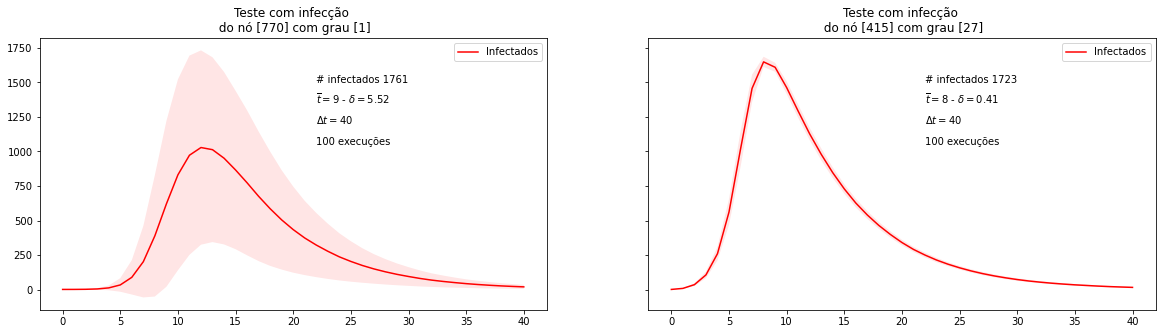

In [7]:
fig, axes = plt.subplots(1, 2, 
                         sharex=True,
                         sharey=True,
                         figsize=(20,5))
steps = 40
xaxis = list(range(steps+1))

for ax, cont in zip(axes.flat, range(2)):
    vp1 = np.empty((0, steps+1))

    #infectados = np.random.choice(range(graph.num_vertices()), cont)
    if cont % 2 == 1:
        infectados = [np.argmax(grau)]
    else:
        infectados = [np.argmin(grau)]
    for x in range(100):
        v1 = []
        condition = graph.new_vertex_property("int")   
        for x in infectados:
            condition[x] = 1
        v1.append(len(infectados))

        state = gtds.SIRState(graph, beta=beta, gamma=gamma,s=condition)
        for i in range(steps):
            iteration = state.iterate_sync()
            s = state.get_state().fa
            v1.append(int((s==1).sum()))
        vp1 = np.append(vp1, [v1], axis=0)
    mu1 = vp1.mean(axis=0)
    
    sigma1 = vp1.std(axis=0)
    ax.plot(xaxis, mu1, label="Infectados", color='red')
    ax.fill_between(xaxis, mu1+sigma1, mu1-sigma1, facecolor='red', alpha=0.1)
    ax.text(22, 1500, '# infectados %d' % vp1.max())
    ax.text(22, 1350, '$ \overline{t} = %2.f $ - $\delta = %.2f $' % (np.argmax(vp1, axis=1).mean(),np.argmax(vp1, axis=1).std()))
    ax.text(22, 1200, '$ \Delta t = 40 $')
    ax.text(22, 1050, '100 execuções')
    ax.legend()
    ax.set_title("Teste com infecção \n do nó {} com grau {}".format(infectados, np.take(grau, infectados)))

Somente um infectado, de maior grau, aumentado-se o número de vacinados em múltiplos de 60. O modelo é executado 100 vezes para cada caso com no máximo 40 iterações.
* Não é possível concluir nada sobre o valor de $\delta$ e do valor de $\overline{i}$
* Existe uma variação do número máximo de infectados $max(i)$ (decréscimo).
* O valor de pico médio de infectados $max(\overline{i})$ também diminui com o número de infectados.

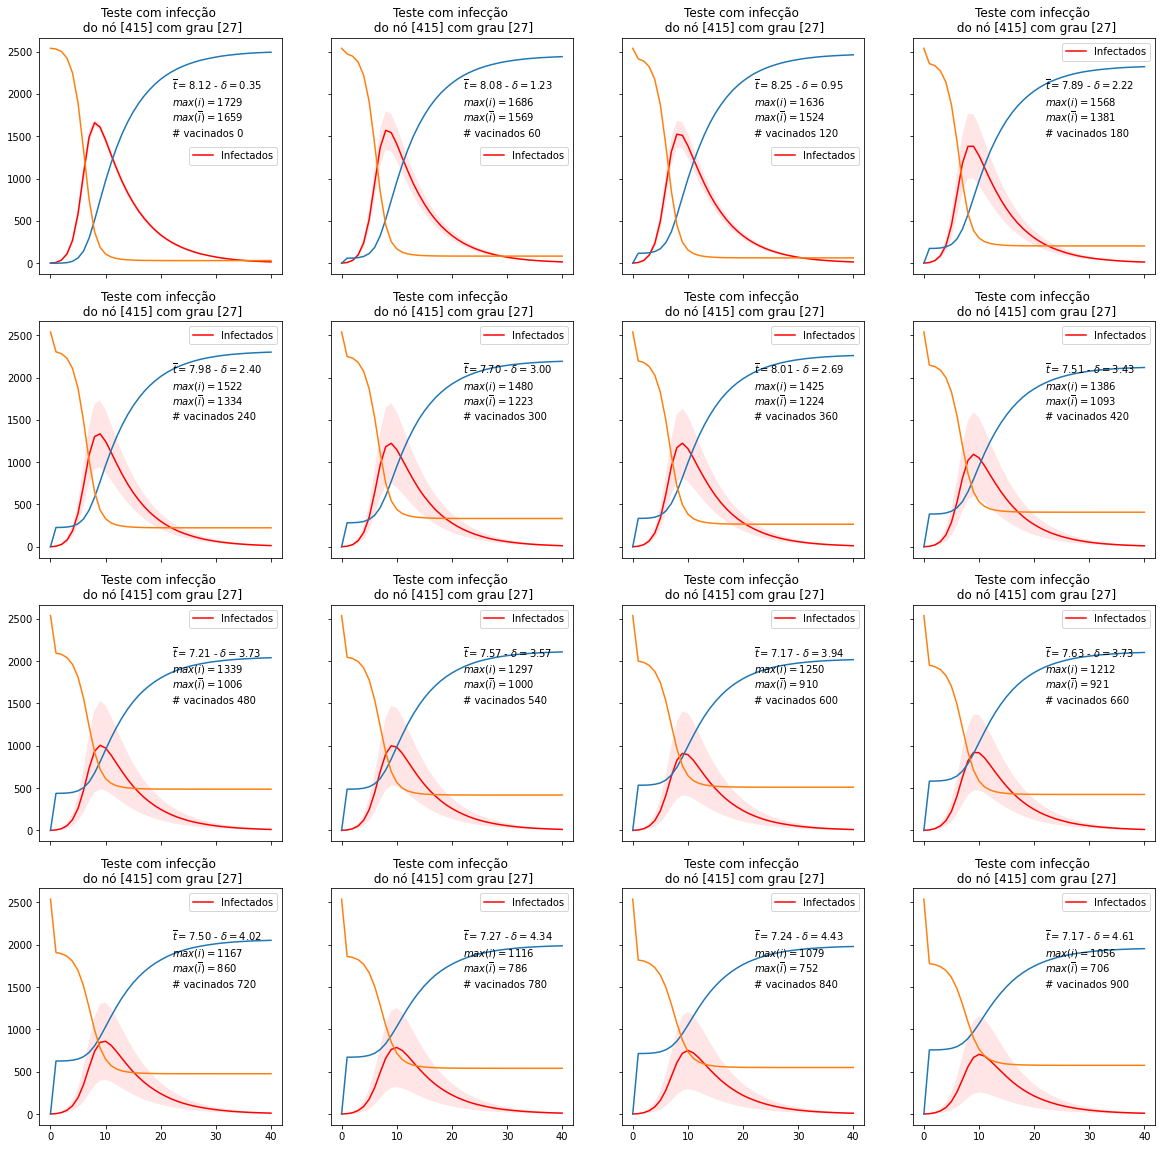

In [8]:
fig, axes = plt.subplots(4, 4, 
                         sharex=True,
                         sharey=True,
                         figsize=(20,20))
steps = 40
xaxis = list(range(steps+1))

for ax, cont in zip(axes.flat, range(16)):
    vp1 = np.empty((0, steps+1))
    vp0 = np.empty((0, steps+1))
    vp2 = np.empty((0, steps+1))

    infectados = [np.argmax(grau)]
    
    for x in range(100):
        v1, v0, v2 = [], [], []
        condition = graph.new_vertex_property("int")   
        for x in infectados:
            condition[x] = 1
        v1.append(len(infectados))
        v0.append(graph.num_vertices()-len(infectados))
        v2.append(0)
        #for x in np.random.choice(range(gh.num_vertices()), nv):
        vacinados = np.random.choice(range(graph.num_vertices()), cont*60)
        for x in vacinados:
            condition[x] = 2

        state = gtds.SIRState(graph, beta=0.2857, gamma=0.1428,s=condition)
        for i in range(steps):
            iteration = state.iterate_sync()
            s = state.get_state().fa
            v1.append(int((s==1).sum()))
            v0.append(int((s==0).sum()))
            v2.append(int((s==2).sum()))
        vp1 = np.append(vp1, [v1], axis=0)
        vp0 = np.append(vp0, [v0], axis=0)
        vp2 = np.append(vp2, [v2], axis=0)
    mu1 = vp1.mean(axis=0)
    mu0 = vp0.mean(axis=0)
    mu2 = vp2.mean(axis=0)
    
    sigma1 = vp1.std(axis=0)
    ax.plot(xaxis, mu1, label="Infectados", color='red')
    ax.plot(xaxis, mu2)
    ax.plot(xaxis, mu0)
    ax.fill_between(xaxis, mu1+sigma1, mu1-sigma1, facecolor='red', alpha=0.1)
    ax.text(22, 1500, '# vacinados %d' % len(vacinados))
    ax.text(22, 1680, '$ max(\overline{i}) = %2.f $' % mu1.max())
    ax.text(22, 1870, '$max(i) = %2.f$' % vp1.max())
    ax.text(22, 2050, '$\overline{t} = %.2f$ - $\delta = %.2f$' % (np.argmax(vp1, axis=1).mean(),np.argmax(vp1, axis=1).std()))
    ax.set_title("Teste com infecção \n do nó {} com grau {}".format(infectados, np.take(grau, infectados)))
    ax.legend()

Sem indivíduos vacinados, aumentando-se o número de infectados em múltiplos de 60
* Quando não há vacinação a variação o $\delta \to 0$, assim como $\overline{t}$ que é inversamente proporcional ao aumento do número de infectados.

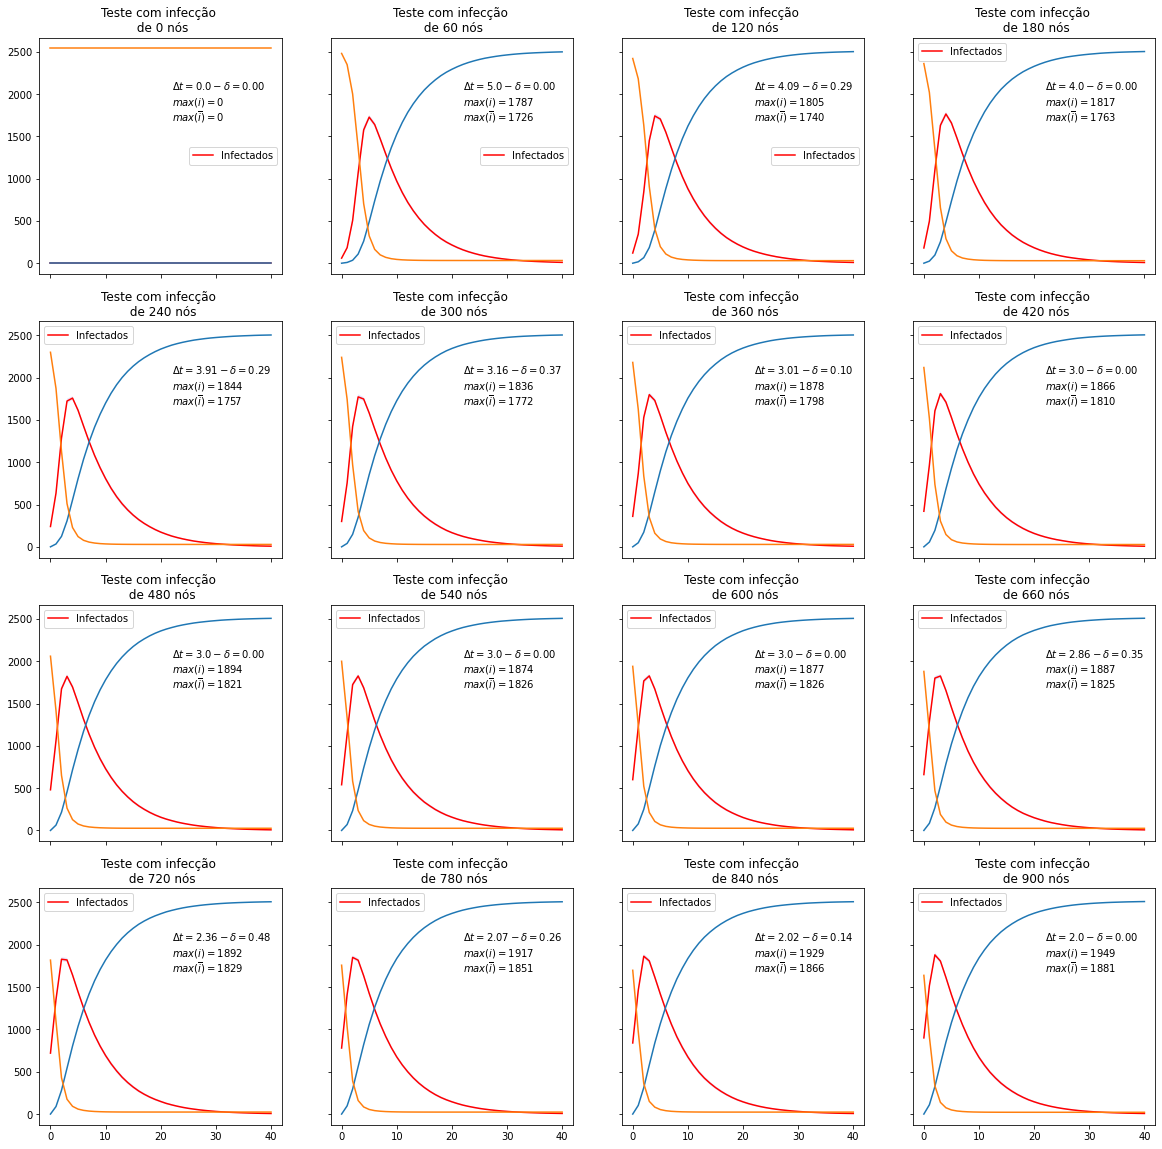

In [9]:
fig, axes = plt.subplots(4, 4, 
                         sharex=True,
                         sharey=True,
                         figsize=(20,20))
steps = 40
xaxis = list(range(steps+1))
vacinados = []

for ax, cont in zip(axes.flat, range(16)):
    vp1 = np.empty((0, steps+1))
    vp0 = np.empty((0, steps+1))
    vp2 = np.empty((0, steps+1))

    #infectados = np.random.choice(range(graph.num_vertices()), cont)
    for x in range(100):
        v1, v0, v2 = [], [], []
        condition = graph.new_vertex_property("int")        
        infectados = np.random.choice(range(graph.num_vertices()), cont*60) 
        for x in infectados:
            condition[x] = 1
        v1.append(len(infectados))
        v0.append(graph.num_vertices()-len(infectados))
        v2.append(0)

        state = gtds.SIRState(graph, beta=0.2857, gamma=0.1428,s=condition)
        for i in range(steps):
            iteration = state.iterate_sync()
            s = state.get_state().fa
            v1.append(int((s==1).sum()))
            v0.append(int((s==0).sum()))
            v2.append(int((s==2).sum()))
        vp1 = np.append(vp1, [v1], axis=0)
        vp0 = np.append(vp0, [v0], axis=0)
        vp2 = np.append(vp2, [v2], axis=0)
    mu1 = vp1.mean(axis=0)
    mu0 = vp0.mean(axis=0)
    mu2 = vp2.mean(axis=0)
    
    sigma1 = vp1.std(axis=0)
    ax.plot(xaxis, mu1, label="Infectados", color='red')
    ax.plot(xaxis, mu2)
    ax.plot(xaxis, mu0)
    ax.fill_between(xaxis, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.1)
    
    
    ax.text(22, 1680, '$ max(\overline{i}) = %2.f $' % mu1.max())
    ax.text(22, 1870, '$max(i) = %2.f$' % vp1.max())
    ax.text(22, 2050, '$\Delta t = {} - \delta = {:.2f}$'.format(np.argmax(vp1, axis=1).mean(),np.argmax(vp1, axis=1).std()))

    ax.legend()
    ax.set_title("Teste com infecção \n de %d nós" % len(infectados))

In [10]:
path = 'out.moreno_health'
graph = gt.load_graph_from_csv(path, csv_options={"delimiter": " "},directed=False)
gts.remove_parallel_edges(graph)
grau = graph.get_out_degrees(graph.get_vertices())
condition = graph.new_vertex_property("int")
condition[0] = 1

state = gtds.SIRState(graph, beta=0.2857, gamma=0.1428,s=condition)
        
iteration = state.iterate_sync(10)

In [11]:
state.get_state().fa

PropertyArray([2, 2, 1, ..., 0, 0, 0], dtype=int32)

In [12]:
state.get_active()

array([2111, 2221,  237, ..., 1342, 1996, 2367], dtype=uint64)

In [13]:
state.reset_active()

In [14]:
state.get_state().fa

PropertyArray([2, 2, 1, ..., 0, 0, 0], dtype=int32)

In [15]:
state.get_active()

array([ 120, 1538,  152, ...,   23,  563,  904], dtype=uint64)